In [ ]:
!pip install mne
!pip install -U mne==1.9.0
!pip install scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 52.0 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import mne
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from collections import Counter
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [ ]:
def extract_bandpowers_epoch(epoch):
    psds, freqs = mne.time_frequency.psd_array_welch(epoch, fmin=0.5, fmax=45, sfreq=128, n_fft=256, verbose=False)

    def bandpower(psd, fmin, fmax):
        idx = np.logical_and(freqs >= fmin, freqs <= fmax)
        return np.sum(psd[:, idx], axis=1).mean()

    delta = bandpower(psds, 0.5, 4)
    theta = bandpower(psds, 4, 8)
    alpha = bandpower(psds, 8, 13)
    beta = bandpower(psds, 13, 30)
    gamma = bandpower(psds, 30, 45)

    return [delta, theta, alpha, beta, gamma]


In [ ]:
def process_edf_file(file_path, label):
    raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)
    raw.filter(0.5, 45, fir_design='firwin', verbose=False)
    raw.resample(128)

    segment_length = 2
    sfreq = int(raw.info['sfreq'])
    n_samples = int(segment_length * sfreq)
    data = raw.get_data()

    features = []
    segment_ids = []
    for start in range(0, data.shape[1] - n_samples, n_samples):
        epoch = data[:, start:start+n_samples]
        if epoch.shape[1] != n_samples:
            continue
        feature_vector = extract_bandpowers_epoch(epoch)


        features.append(feature_vector)
        segment_ids.append(file_path)

    labels = [label] * len(features)
    return features, labels, segment_ids



In [ ]:
base_path = '/content/drive/MyDrive/EEG_signal(1)'
labels = {'H': 0, 'MDD': 1}

all_features = []
all_labels = []
file_ids = []

for folder, label in labels.items():
    folder_path = os.path.join(base_path, folder)
    for file in os.listdir(folder_path):
        if file.endswith('.edf'):
            try:
                full_path = os.path.join(folder_path, file)
                feats, labs, ids = process_edf_file(full_path, label)
                all_features.extend(feats)
                all_labels.extend(labs)
                file_ids.extend(ids)
                print(f"[✓] Processed {file} into {len(feats)} segments")
            except Exception as e:
                print(f"[✗] Failed {file}: {e}")

[✓] Processed H S5 EC.edf into 151 segments
[✓] Processed H S2 TASK.edf into 302 segments
[✓] Processed H S1 EO.edf into 175 segments
[✓] Processed H S4 TASK.edf into 302 segments
[✓] Processed H S2 EO.edf into 150 segments
[✓] Processed H S2 EC.edf into 150 segments
[✓] Processed H S3 EO.edf into 152 segments
[✓] Processed H S3 TASK.edf into 302 segments
[✓] Processed H S4 EC.edf into 150 segments
[✓] Processed H S5 EO.edf into 155 segments
[✓] Processed H S1 TASK.edf into 302 segments
[✓] Processed H S1 EC.edf into 149 segments
[✓] Processed H S3 EC.edf into 150 segments
[✓] Processed H S4 EO.edf into 147 segments
[✓] Processed H S9 EO.edf into 150 segments
[✓] Processed H S7 EO.edf into 151 segments
[✓] Processed H S7 TASK.edf into 302 segments
[✓] Processed H S8 TASK.edf into 304 segments
[✓] Processed H S11 EO.edf into 150 segments
[✓] Processed H S9 EC.edf into 150 segments
[✓] Processed H S6 EO.edf into 151 segments
[✓] Processed H S6 EC.edf into 150 segments
[✓] Processed H S8 

In [ ]:
df = pd.DataFrame(all_features, columns=['delta', 'theta', 'alpha', 'beta', 'gamma'])
df['label'] = all_labels
df['file_id'] = file_ids

In [ ]:
X = df[['delta', 'theta', 'alpha', 'beta', 'gamma']].values
y = df['label'].values

In [ ]:
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
unique_files = df['file_id'].unique()
np.random.seed(42)
np.random.shuffle(unique_files)

split_index = int(0.8 * len(unique_files))
train_files = unique_files[:split_index]
test_files = unique_files[split_index:]

train_idx = df['file_id'].isin(train_files)
test_idx = df['file_id'].isin(test_files)

X_train, y_train = X_scaled[train_idx], y[train_idx]
X_test, y_test = X_scaled[test_idx], y[test_idx]
file_test_ids = df['file_id'][test_idx].values

In [ ]:
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
# Predict labels for each EEG segment in the test set
segment_preds = clf.predict(X_test)

# Majority voting
file_predictions = {}
for pred, file, true_label in zip(segment_preds, file_test_ids, y_test):
    if file not in file_predictions:
        file_predictions[file] = {'preds': [], 'true': true_label}
    file_predictions[file]['preds'].append(pred)

# Count correct votes
correct = 0
total = 0
for file, data in file_predictions.items():
    majority_vote = Counter(data['preds']).most_common(1)[0][0]
    if majority_vote == data['true']:
        correct += 1
    total += 1

print(f"\n Accuracy: {correct/total:.2f}")



 Accuracy: 0.97


In [ ]:
def predict_new_edf(file_path):
    raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)
    raw.filter(0.5, 45, fir_design='firwin', verbose=False)
    raw.resample(128)

    segment_length = 2
    sfreq = int(raw.info['sfreq'])
    n_samples = int(segment_length * sfreq)
    data = raw.get_data()

    features = []
    for start in range(0, data.shape[1] - n_samples, n_samples):
        epoch = data[:, start:start+n_samples]
        if epoch.shape[1] != n_samples:
            continue
        feats = extract_bandpowers_epoch(epoch)  # Use updated version
        features.append(feats)

    if not features:
        return "File too short or unreadable."

    features = scaler.transform(features)
    preds = clf.predict(features)
    majority_vote = Counter(preds).most_common(1)[0][0]
    return "Healthy" if majority_vote == 0 else "Depressed"


In [ ]:
test_file = "/content/H S5 EC.edf"  # Your test EEG file path
result = predict_new_edf(test_file)
print("Prediction for new file:", result)

Prediction for new file: Healthy


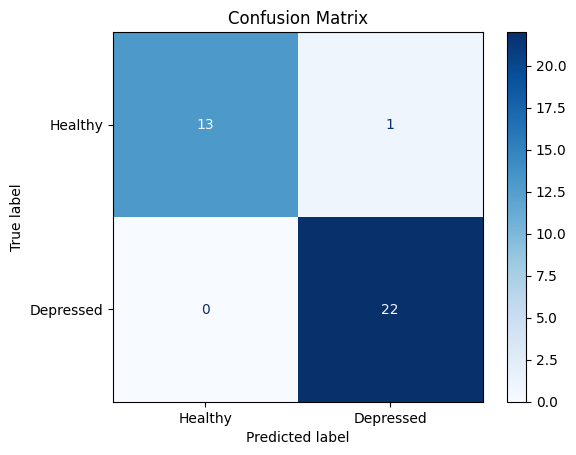

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_true = []
y_pred = []

for file, data in file_predictions.items():
    majority_vote = Counter(data['preds']).most_common(1)[0][0]
    y_true.append(data['true'])
    y_pred.append(majority_vote)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Healthy", "Depressed"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


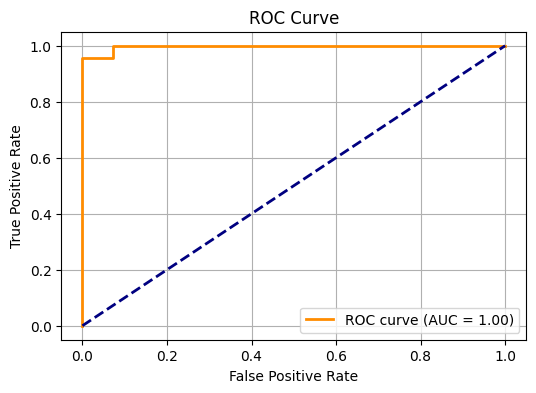

In [ ]:
from sklearn.metrics import roc_curve, auc
file_probs = {}
segment_probs = clf.predict_proba(X_test)[:, 1]

for prob, file in zip(segment_probs, file_test_ids):
    if file not in file_probs:
        file_probs[file] = []
    file_probs[file].append(prob)

y_score = []
y_true = []
for file, probs in file_probs.items():
    avg_prob = np.mean(probs)
    y_score.append(avg_prob)
    y_true.append(file_predictions[file]['true'])

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

# Plotting
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


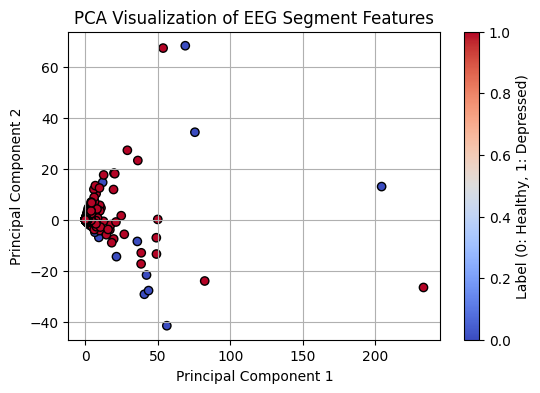

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Apply PCA to segment-level scaled features
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)  # X_scaled from StandardScaler

# Plot PCA components with true labels
plt.figure(figsize=(6, 4))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='coolwarm', edgecolors='k')
plt.title("PCA Visualization of EEG Segment Features")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label="Label (0: Healthy, 1: Depressed)")
plt.grid(True)
plt.show()
